In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
# from tokenizers import BertWordPieceTokenizer
import matplotlib.pyplot as plt
# import torch.nn as nn
import seaborn as sns
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

C:\Users\YC\.conda\envs\SDPtest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_frame =pd.read_json("resources/embold_train.json").reset_index(drop=True)

In [3]:
train_df= pd.read_json("resources/embold_train.json").reset_index(drop=True)
train_df.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [4]:
test_df= pd.read_json("resources/embold_test.json").reset_index(drop=True)
test_df.head()

,title,body
0,config question path-specific environment var...,issue description or question\r \r hey @artemg...
1,crash indien vol,de simulator crasht als hij vol zit
2,unable to mine rocks,"sarkasmo starting today, when i hit enter act..."
3,not all whitelists are processed,create following rules... order of creation is...
4,add ctx menu for idafree 70 and idafree 5,"associated with .dll, .dll_, .exe, .exe_, .sc,..."


In [5]:
train_ex_df= pd.read_json("resources/embold_train_extra.json").reset_index(drop=True)
train_ex_df.head()

,title,body,label
0,use a 8bit typeface,since this is meant to emulate some old arcade...,1
1,implement wireless m-bus binding,_from chris.pa...@googlemail.com https://cod...,1
2,add multilang support for timeago.js,currently it is only en . \r required to add ...,1
3,scaleway - seg-fault on shutdown,tbr irc creates a new scaleway instance with...,0
4,sistema de pintura: no se guardar los nuevos p...,este sp ya estaba asignado a un carro y se enc...,0


In [6]:
def dataset_length_check(data_frame):
    print(len(data_frame),data_frame.index.shape[-1])
                 
dataset_length_check(train_df)
dataset_length_check(train_ex_df)
dataset_length_check(test_df)

150000 150000
300000 300000
30000 30000


In [7]:
data_frame = pd.concat([train_df,train_ex_df],ignore_index=True)
data_frame.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [8]:
dataset_length_check(data_frame)

450000 450000


Total Counts of label column: 
 label
1    207318
0    200481
2     42201
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

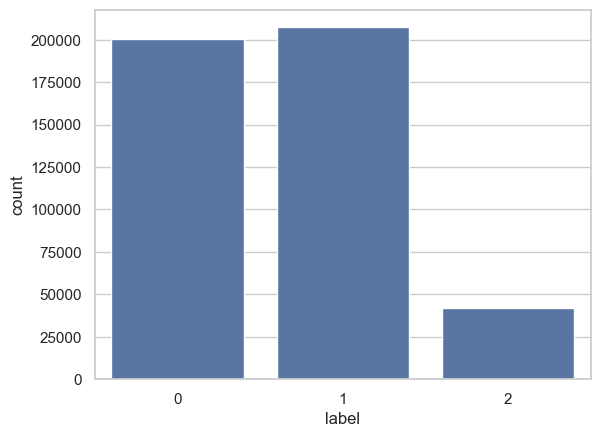

In [9]:
print('Total Counts of label column: \n'.format(),data_frame['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=data_frame)

In [10]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   450000 non-null  object
 1   body    450000 non-null  object
 2   label   450000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB


### type of label
#### Bug - 0
#### Feature - 1
#### Question - 2

In [11]:
df_bug = data_frame[data_frame['label']==0]
df_feature = data_frame[data_frame['label']==1]
df_question = data_frame[data_frame['label']==2]

In [12]:
label_counts = data_frame.label.value_counts().sort_index()
label_counts

label
0    200481
1    207318
2     42201
Name: count, dtype: int64

In [13]:
def fx(x):
    return x['title'] + " " + x['body']   
data_frame['text']= data_frame.apply(lambda x : fx(x),axis=1)
data_frame['text']= data_frame.apply(lambda x : fx(x),axis=1)

### Count the Lables : Bug, Feature abd Questions

In [14]:
print('Number of datapoints with label as Bug :',label_counts[0])
print('Number of datapoints with label as Feature :',label_counts[1])
print('Number of datapoints with label as Question :',label_counts[2])

Number of datapoints with label as Bug : 200481
Number of datapoints with label as Feature : 207318
Number of datapoints with label as Question : 42201


In [15]:
import nltk
import re
import string

In [16]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [17]:
from string import punctuation
from nltk.corpus import stopwords

def remove_stopwords(git_text):
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_git_text

In [18]:
from collections import Counter
import plotly.express as px

In [1]:
def visulize_dataset(data_frame, category):
    
    # apply the above two functions 'clean_text' and 'remove_stopwords' to the whole dataset

    data_frame['text'] = data_frame['text'].apply(lambda x: x.replace("\\r", ""))
    data_frame['text'] = data_frame['text'].apply(lambda x: clean_text(x))
    data_frame["text"] = data_frame["text"].apply(remove_stopwords)
    
    
    word_list = []
    
    for i, j in data_frame.iterrows():
        for word in j['text']:
            word_list.append(word)
        
    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    fig = px.histogram(most_common_words_df,
                       x='word', 
                       y='count',
                       title='Most common terms used while refering to a GitHub {}'.format(category),
                       color_discrete_sequence=['#843B62'] )
    fig.show()

In [20]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
data_frame['text'] = data_frame['text'].apply(lambda x: x.replace("\\r", ""))
data_frame['text'] = data_frame['text'].apply(lambda x: clean_text(x))
data_frame.head()

,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,yzoom piano roll a yzoom on the piano roll wou...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,auto update feature hi great job so far saenz...
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on pid off alarm actions for expe...


In [21]:
data_frame.head()
data_frame.describe

<bound method NDFrame.describe of                                                     title  \
0                                       y-zoom piano roll   
1                             buggy behavior in selection   
2                                     auto update feature   
3                      filter out noisy endpoints in logs   
4       enable pid on / pid off alarm actions for ardu...   
...                                                   ...   
449995                       shield against invalid dates   
449996                                     fix the knight   
449997  portaudio playback binding crashes often, ubun...   
449998  add --db-path option for allowing user to spec...   
449999                 staff users cannot log in to admin   

                                                     body  label  \
0             a y-zoom on the piano roll would be useful.      1   
1       ! screenshot from 2016-02-23 21 27 40  https:/...      0   
2       hi,\r \r great job so

In [22]:
# set random seed, reproduce results
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [23]:

class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 64
    VALID_BATCH_SIZE = 16
    EPOCHS = 5
    BERT_PATH = "bert-base-uncased"
    MODEL_PATH = "bert-base-uncased/pytorch_model.bin"
    tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
    truncation=True

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BertModel.from_pretrained("bert-base-uncased")
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.99, weight_decay=0.005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model.to(device)
criterion.to(device)

BCEWithLogitsLoss()

In [25]:
BERT_PATH = "bert-base-uncased"

In [26]:
#loading the pre-trained BertTokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)

### BERT conversion of sentences

In [27]:
# some basic operations to understand how BERT converts a sentence into tokens and then into IDs
sample_body = 'script stopped adding videos saenzramiro abc xyz'
tokens = tokenizer.tokenize(sample_body)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_body}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: script stopped adding videos saenzramiro abc xyz
   Tokens: ['script', 'stopped', 'adding', 'videos', 'sa', '##en', '##z', '##ram', '##iro', 'abc', 'x', '##y', '##z']
Token IDs: [5896, 3030, 5815, 6876, 7842, 2368, 2480, 6444, 9711, 5925, 1060, 2100, 2480]


In [28]:
# using encode_plus to add special tokens : [CLS]:101, [SEP]:102, [PAD]:0
encodings = tokenizer.encode_plus(
            sample_body,
            max_length=32,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
)

encodings.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [29]:
print('Input IDs : {}'.format(encodings['input_ids'][0]))
print('\nAttention Mask : {}'.format(encodings['attention_mask'][0]))

Input IDs : tensor([ 101, 5896, 3030, 5815, 6876, 7842, 2368, 2480, 6444, 9711, 5925, 1060,
        2100, 2480,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Attention Mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [2]:
MAX_LENGTH = 512

### Construct a Class for GitHub Messages

In [31]:
class Git_Message(Dataset):
    def __init__(self, git_messages, label, tokenizer, max_len):
        self.git_messages = git_messages
        self.label = label
        self.tokenizer = config.tokenizer
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.git_messages)

    def __getitem__(self, item):
        git_messages = str(self.git_messages[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
        git_messages,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'git_messages': git_messages,
         'input_ids': encoding['input_ids'],
         'attention_mask': encoding['attention_mask'],
         'label': torch.tensor(label, dtype=torch.long)
          }

### Creating Train, Test Validation

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
data_frame.head()
data_frame = data_frame[:2000]

In [34]:
training_data, testing_data = train_test_split(
    data_frame,
    test_size=0.1,
    random_state=RANDOM_SEED
)

testing_data, validation_data = train_test_split(
    testing_data,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [35]:
training_data.shape, testing_data.shape, validation_data.shape

((1800, 4), (100, 4), (100, 4))

### Creating Data Loader

In [36]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = Git_Message(git_messages=data.text.to_numpy(),
    label=data.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)


BATCH_SIZE = 16
train_data_loader = create_data_loader(training_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
testing_data_loader = create_data_loader(testing_data, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(validation_data, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [ ]:
data_frame = next(iter(train_data_loader))
data_frame.keys()

In [ ]:
data_frame['input_ids'].squeeze().shape, data_frame['attention_mask'].squeeze().shape, data_frame['label'].shape

In [ ]:
print('git_messages  : ', data_frame['git_messages'][0])
print('input_ids : ', data_frame['input_ids'].squeeze()[0])
print('attention_mask : ', data_frame['attention_mask'].squeeze()[0])
print('label : ', data_frame['label'][0])

In [ ]:
bert_model = BertModel.from_pretrained(BERT_PATH)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encodings['input_ids'],
  attention_mask=encodings['attention_mask']
)

In [ ]:
last_hidden_state.shape, pooled_output.shape

### Predictor Model

In [ ]:
import torch.nn as nn

In [ ]:
class BugPredictor(nn.Module):
    
    def __init__(self, n_classes):
        super(BugPredictor, self).__init__()
        self.bert_model = BertModel.from_pretrained(BERT_PATH)
        self.dropout = nn.Dropout(p=0.0)
        self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert_model(
        input_ids=input_ids,
        attention_mask = attention_mask
        )
        output = self.dropout(pooled_output)
        return self.out(output)

### Let's Start Training the Model

In [ ]:
"""
label 0: Bug
label 1: Feature
label 2: Question
"""
class_names = [0, 1, 2]
bug_predictor_model = BugPredictor(len(class_names))
bug_predictor_model = bug_predictor_model.to(device)

In [ ]:
EPOCHS = 10

optimizer = AdamW(bug_predictor_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].squeeze().to(device)
        attention_mask = d['attention_mask'].squeeze().to(device)
        targets = d['label'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].squeeze().to(device)
            attention_mask = d['attention_mask'].squeeze().to(device)
            targets = d['label'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('EPOCH {}/{}'.format(epoch+1,EPOCHS))
    print('-' * 10)
  
    train_acc, train_loss = train_model(bug_predictor_model, train_data_loader, loss_fn, optimizer, device, scheduler, len(training_data))
    
    print('Train loss : {} accuracy : {}'.format(train_loss, train_acc))
    
    val_acc, val_loss = eval_model(bug_predictor_model, val_data_loader, loss_fn, device, len(validation_data))
    
    print('Validation loss : {} accuracy : {}'.format(val_loss, val_acc))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print('Saving the best model ...')
        torch.save(bug_predictor_model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc

### Results

In [ ]:
sample_bug_message = "Script stopped adding video's. A recent change in the youtube layout broke the script. Probably caused by element names being altered."

In [ ]:
class_names = ['bug', 'feature', 'question']

In [ ]:
def predict_git_category(sample_message, model):
    encoded_message = tokenizer.encode_plus(sample_bug_message, max_length=MAX_LENGTH, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    input_ids = encoded_message['input_ids'].to(device)
    attention_mask = encoded_message['attention_mask'].to(device)
    
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction_idx = torch.max(output, dim=1)
        
    return class_names[prediction_idx]

In [ ]:
print('Sample bug message : ', sample_bug_message)
print('Predicted GitHub Category : ', predict_git_category(sample_bug_message, bug_predictor_model))